# BIOINF 305. Assignment - week 35.
## Assem Maratova

- Obtain the TF-gene transcriptional network from E. coli from RegulonDB (Links to an external site.) (a copy is also available on Mitt > Files).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting some parameters for plots
plt.style.use('seaborn')
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.rcParams['figure.figsize'] = 10 , 6 # default figure size

In [3]:
data = pd.read_table('network_tf_gene.txt', 
                     header=None, 
                     skiprows=34, 
                     usecols=[0,1,2,4])
# standardize the data
for col in [0,1,2,4]:
    data[col] = data[col].astype(str).str.lower()

# rename columns to ease reading
data = data.rename(columns={0:'tf', 
                            1:'gene', 
                            2:'effect', 
                            4:'power'})

# filter the data 
filtered = (data['effect'].isin(['+','-'])) & (data['power']=='strong')

# drop duplicate rows having same tf and gene 
data = data[filtered].drop_duplicates(subset=['tf','gene'])

In [4]:
data = pd.read_table('network_tf_gene.txt', 
                     header=None, 
                     skiprows=34, 
                     usecols=[0,1,2,4])
# standardize the data
for col in [0,1,2,4]:
    data[col] = data[col].astype(str).str.lower()

# rename columns to ease reading
data = data.rename(columns={0:'tf', 
                            1:'gene', 
                            2:'effect', 
                            4:'power'})

# filter the data 
filtered = (data['effect'].isin(['+','-'])) & (data['power']=='strong')

# drop duplicate rows having same tf and gene 
data = data[filtered].drop_duplicates(subset=['tf','gene'])

- Write a script that reads the transcriptional network from E. coli and produces a square adjacency matrix A, where A(i,j)=1 if gene i activates gene j, -1 if gene i inhibits gene j, and 0 otherwise. Index the genes alphabetically.

In [5]:
# create a sorted list of nodes in the network
nodes = data.tf.append(data.gene).unique().tolist()
nodes = sorted(nodes)

In [6]:
# create a dictionary with nodes names and their indexes
n = len(nodes)
nodes_dict = dict(zip(nodes, np.arange(n)))

In [7]:
# create an empty matrix Adj_mat of size n-by-n
Adj_mat = np.empty(shape=(n, n), dtype=int)

In [8]:
# fill in Adj_mat with 1 and -1 according to the data
for i in data.index:
    r =nodes_dict[data.loc[i,'tf']] 
    c = nodes_dict[data.loc[i,'gene']]
    if data.loc[i,'effect'] == '+':    
        Adj_mat[r,c] = 1
    elif data.loc[i,'effect'] == '-':
        Adj_mat[r,c] = -1

In [9]:
pd.DataFrame(Adj_mat, index = nodes, columns = nodes).head()

acea  aceb  acek  acna  acra  acrb  acrd  acrr  ada  adhe ...   znta  \
acea     0     0     0     0     0     0     0     0    0     0 ...      0   
aceb     0     0     0     0     0     0     0     0    0     0 ...      0   
acek     0     0     0     0     0     0     0     0    0     0 ...      0   
acna     0     0     0     0     0     0     0     0    0     0 ...      0   
acra     0     0     0     0     0     0     0     0    0     0 ...      0   

      zntr  znua  znub  znuc  zrap  zrar  zras  zur  zwf  
acea     0     0     0     0     0     0     0    0    0  
aceb     0     0     0     0     0     0     0    0    0  
acek     0     0     0     0     0     0     0    0    0  
acna     0     0     0     0     0     0     0    0    0  
acra     0     0     0     0     0     0     0    0    0  

[5 rows x 1094 columns]

- Write a script that samples 1,000 randomized networks with the same number of nodes and edges as the real transcriptional network (ignoring edge signs) and where each TF has the same number of target genes as in the real network.

In [10]:
# number of self edges in the network
data_n_self_edges = sum(data['tf']==data['gene'])

# make 1000 randomized networks and count their self edges
np.random.seed(305)
random_n_self_edges = np.zeros(1000)

for i in range(1000):
    rand_n = sum(data['tf']==np.random.permutation(data['gene']))
    random_n_self_edges[i] = rand_n

- Test if autoregulation is significantly more frequent in the real network than in the randomized networks.

In [11]:
avg_n_self_edges = np.mean(random_n_self_edges) 

print('Number of self edges in the network: ', data_n_self_edges)
print('Average number of self edges in random networks: ', avg_n_self_edges)

print('t-test result on equal means')
from scipy.stats import ttest_ind
ttest_ind([data_n_self_edges]*1000,
          random_n_self_edges, 
          equal_var = False)

Number of self edges in the network:  61
Average number of self edges in random networks:  1.278
t-test result on equal means


Ttest_indResult(statistic=1726.969817119714, pvalue=0.0)

*p-value = 0.0* shows that there is a significantly higher autoregulation in the given network when compared to a random network.


- Compare the dynamics of negative autoregulation vs. simple gene regulation for genes having the same steady state expression level and the same degradation rate. Use a Hill function with exponent n to model the production rate in autoregulation.

In [12]:
def NAR(x,t,beta,alpha,K,h):
    f = beta/(1+(x/K)**h)
    dxdt = f - alpha*x
    return dxdt

def Ordinary_regulation(x,t,beta,alpha):
    dxdt = beta - alpha*x 
    return dxdt

In [13]:
from scipy.integrate import odeint
from scipy.optimize import fsolve

In [14]:
# defining parameters 
t = np.linspace(0,5,100) 
beta = 5 
alpha = 1.5 
K = 2
h = 2
x_st = fsolve(NAR,
             args=(t,beta,alpha,K,h),
             x0=K) 
beta_st = x_st*alpha 
print('Beta for ordinary regulation: ', np.round(beta_st,3))

Beta for ordinary regulation:  [2.733]


In [15]:
x0 = 0 
x_auto = odeint(NAR,x0,t,
                args=(beta,alpha,K,h))
x_auto = x_auto.reshape(x_auto.shape[0])

x_ordinary = odeint(Ordinary_regulation,x0,t,
                   args=(beta_st,alpha))
x_ordinary = x_ordinary.reshape(x_ordinary.shape[0])

In [16]:
time_nar = K/(beta*2) 
time_ordinary = np.log(2)/alpha 
print("Response time for NAR: ", time_nar)
print("Response time for ordinary regulation: ", 
      np.round(time_ordinary,3))

Response time for NAR:  0.2
Response time for ordinary regulation:  0.462


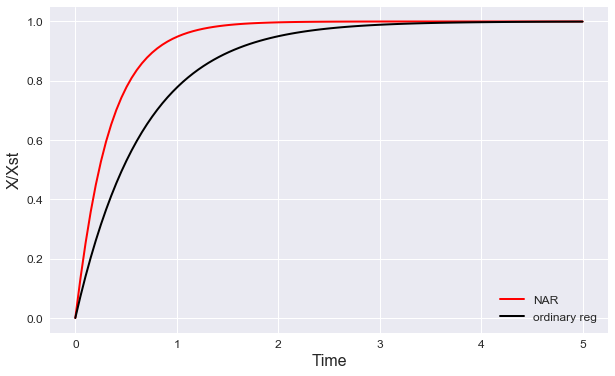

In [17]:
plt.plot(t,x_auto/x_st, color='r', lw = 2, label='NAR')
plt.plot(t,x_ordinary/x_st, color='k', lw = 2, label='ordinary reg')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('X/Xst')
plt.show()